# Approximation of Laplacian zero modes
In this example notebook, the second in of a pair, we consider a complex manifold $X$, and approximate the zero modes of the Laplacian $\Delta_g$ on $X$ by optimisation of the natural associated variational problem. One may regard this as an example of how to use the approximate metric to study the geometry of $X$.

The manifold $X$ is the same Calabi-Yau threefold defined in the previous example, where we found an approximation to the unique Ricci-flat metric tensor on $X$. We will use the points sampled and optimsed parameters saved by the previous example.

In [1]:
import jax
from jax import random
import jax.numpy as jnp

import os, time
import numpy as np

from functools import partial

from cymyc import dataloading
from cymyc.utils import gen_utils as utils

## Motivation

This will be a brief overview with technical details smoothed over for the ease of exposition - for the full story, please [consult this article](https://arxiv.org/abs/2407.13836). 

We are interested in differential forms on the Calabi-Yau, $\eta \in \Omega^1(X)$, which are annihilated by the Laplacian on $X$,
$$ \Delta_g \eta = 0~.$$

Evaluation of the Laplacian requires the metric on $X$ - which makes sense, as [eigenmodes on manifolds should tell you about geometry!](https://www.math.ucdavis.edu/~hunter/m207b/kac.pdf) For physical reasons, in string compactification scenarios, we are interested in eigenmodes which are harmonic w.r.t. the Ricci-flat metric. These correspond to observable physical matter fields in string compactifications scenarios.

With harmonic forms in hand, we may predict the masses and strengths with which these particles interact at low energies. The end goal is to predict if a given 'string model' (of which there are exceptionally many) recovers a quantum field theory with properties close to our universe at low energies.

## Load data and metric checkpoint

We load the points sampled from $X$ in the previous notebook, as well as the parameters for the approximate Ricci-flat metric.

In [2]:
class args(object):
    # specify training config. For more options, see `src/approx/default_config`
    name = "X33_demo_harmonic"
    learning_rate = 1e-4
    n_epochs = 24
    dataset = "data/X33_demo/"
    metric_checkpoint = "experiments/X33_demo/X33_demo_epoch_FIN_2024_08_21_01:10_PARAMS.pkl" # replace this with your checkpoint
    batch_size = 1024
    n_units_harmonic = [64, 64, 128, 64, 42]

# Override default arguments from config file with provided command line arguments
from cymyc.approx.default_config import config
config = utils.override_default_args(args, config)
config = utils.read_metadata(config)  # load dataset metadata

np_rng = np.random.default_rng()
data_train, data_val, train_loader, val_loader, psi = dataloading.initialize_loaders_train(
    np_rng      = np_rng,
    data_path   = os.path.join(config.dataset, "dataset.npz"),
    batch_size  = config.batch_size)

Saving config file to experiments/X33_demo_harmonic/X33_demo_harmonic_METADATA.pkl
Dataset size: (400000, 12), kappa: 0.0393404
Vol[g]: 0.0277778, Vol[Ω]: 0.7060880


In [3]:
from cymyc.approx import models

metric_model_class = models.LearnedVector_spectral_nn_CICY
metric_model = metric_model_class(config.n_ambient_coords, config.ambient, config.n_units)

seed = int(time.time()) # 42
rng = random.PRNGKey(seed)
rng, init_rng = random.split(rng)

_params, init_rng = utils.random_params(init_rng, metric_model, data_dim=config.n_ambient_coords * 2)
metric_params = utils.load_params(_params, config.metric_checkpoint)  # parameters for trained metric NN

Compiling LearnedVector_spectral_nn.spectral_layer.


## Harmonic model ansatz

Our variational ansatz $\tilde{\eta}_{\lambda}$ is obtained as an $\overline{\partial}$-exact correction from some easily computable reference form $\phi \in H^1(T_X)$, and the natural variational objective to minimise is the Laplacian itself,

$$\tilde{\eta}(\cdot; \lambda) = \phi + \bar{\partial} \mathfrak{s}(\cdot; \lambda), \quad \lambda = \textsf{argmin}_{\lambda' \in \Lambda} \Delta_g \tilde{\eta}(\cdot; \lambda').$$

Here $\mathfrak{s}$ is a section of the (holomorphic) tangent bundle over $X$. The approximation problem thus reduces to finding a way to model a section of the tangent bundle $\mathfrak{s} \in \Gamma(T_X)$ using a parameterised function - this is far from obvious on a manifold with nontrivial topology! 

The core idea is to construct a basis of sections $\{ \mathbf{e}^i \}_i$ of $T_X$, and to take $\mathfrak{s}$ to be a linear combination of the basis elements, with the coefficients parameterised by a vector-valued globally defined function $\psi$:
$$ \mathfrak{s} = \sum_{\mu} \psi_{\mu} \mathbf{e}^{\mu} ~.$$
We again we leave the full story to [this article](https://arxiv.org/abs/2407.13836), but note this is crucial to ensure that $\tilde{\eta}$ is a bona-fide geometrical object globally defined over $X$ - one gets nonsensical answers if the ansatz does not respect the topology of $X$.

**Note:** The objective requires taking the third derivative of the neural network modelling the metric, so this example runs significantly faster on a GPU.

In [4]:
from flax import linen as nn
from functools import partial

from cymyc.approx import harmonic, eta_train

In [5]:
# initialize model
eta_model_class = models.CoeffNetwork_spectral_nn_CICY
eta_model = eta_model_class(
    dim         = config.n_ambient_coords,
    ambient     = config.ambient,
    n_units     = config.n_units_harmonic,
    activation  = nn.gelu)

t0 = time.time()
rng, init_rng = random.split(rng)
logger = utils.logger_setup('X33_demo_harmonic', filepath=os.path.abspath(''))
logger.info(eta_model.tabulate(init_rng, jnp.ones([1, config.n_ambient_coords * 2])))

01:33:03 INFO - logger_setup: /home/jt796/github/alpha_prime/docs/examples
01:33:03 INFO - <module>: 
                     CoeffNetwork_spectral_nn_CICY Summary                      
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ path          ┃ module        ┃ inputs        ┃ outputs       ┃ params       ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│               │ CoeffNetwork… │ float32[1,12] │ -             │              │
│               │               │               │ complex64[1,… │              │
├───────────────┼───────────────┼───────────────┼───────────────┼──────────────┤
│ layers_0      │ Dense         │ float32[36]   │ float32[64]   │ bias:        │
│               │               │               │               │ float32[64]  │
│               │               │               │               │ kernel:      │
│               │               │               │               │ float32[36,… │
│      

Compiling LearnedVector_spectral_nn.spectral_layer.
CoeffNetwork_spectral_nn_CICY.__call__, coeff shape, (1, 15, 21)


For the particular manifold we consider, there is one unique harmonic one-form, as $h^{(2,1)} = 1$. Topological considerations mean the number of harmonic one-forms is equal to the number of independent ways we can deform the defining polynomials while remaining on the zero locus. From the definition of the manifold as the intersection of zero loci in $\mathbb{P}^5$, there is only one way to do this,

$$
B_{\psi} = \left\{\begin{array}{c}Z_0^3 + Z_1^3 + Z_2^3 - 3 \psi Z_3 Z_4 Z_5 = 0\\
Z_3^3 + Z_4^3 + Z_5^3 - 3 \psi Z_0 Z_1 Z_2 = 0\end{array} \, : \, \psi \in \mathbb{C}\right\} \subset \mathbb{P}^5~.
$$

The single complex structure moduli direction corresponds to the trilinear polynomial deformations above, and we can write down this deformation explicitly. We also need to calculate some complex structure data associated with the manifold.

There's too much information to comfortably carry around as arguments to functions used in optimisation. To remedy this, we wrap everything up into an appropriately filtered class - `harmonic_wp`, whose methods are compatible with `Jax` transformations.

In [6]:
from cymyc import alg_geo
from examples import poly_spec

def X33_deformation(p, precision=np.complex128):
    d1 = jnp.einsum("...a,aj->...j", jnp.expand_dims(p[3]*p[4]*p[5], axis=-1),
                      jnp.asarray([[-3.,0.]], precision))
    d2 = jnp.einsum("...a,aj->...j", jnp.expand_dims(p[0]*p[1]*p[2], axis=-1),
                      jnp.asarray([[0.,-3.]], precision))
    return d1 + d2

def _X33_coefficients(psi):
    coefficients = [jnp.append(jnp.ones(3), -3.0*psi), jnp.append(jnp.ones(3), -3.0*psi)]
    return coefficients
    
monomials, cy_dim, kmoduli, ambient = poly_spec.X33_spec()
coefficients = _X33_coefficients(psi)

dQdz_info = [alg_geo.dQdz_poly(config.n_ambient_coords, m, c) for (m,c) in zip(monomials, coefficients)]
dQdz_monomials, dQdz_coeffs = list(zip(*dQdz_info))
config.dQdz_monomials = dQdz_monomials
config.dQdz_coeffs = dQdz_coeffs

In [7]:
g_FS_fn, g_correction_fn, pb_fn = models.helper_fns(config)
# full transformation-compatible closure
metric_fn = jax.tree_util.Partial(models.ddbar_phi_model, params=metric_params, 
                                  g_ref_fn=g_FS_fn, g_correction_fn=g_correction_fn)
harmonic_wp = harmonic.HarmonicFull(cy_dim, monomials, ambient, [X33_deformation], dQdz_monomials,
                                dQdz_coeffs, metric_fn, pb_fn, _X33_coefficients, psi)

## Optimisation loop for harmonic zero modes

This is again fairly standard - note Jax is more bare-metal than other libraries, so we write the looping logic ourselves. 

`jit` compilation introduces a delay the first time the `train_step` function is called, but executes quickly when called subsequently. We pay an initial up-front cost for compilation of Python functions into a form efficiently executable by an accelerator, which will be repaid during the execution itself.

In [8]:
import time, logging
import optax

from tqdm import tqdm
from collections import defaultdict

optimizer = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adamw(config.learning_rate))
params, opt_state, init_rng = eta_train.create_train_state(init_rng, eta_model, optimizer, data_dim=config.n_ambient_coords * 2)

storage = defaultdict(list)

try:
    device = jax.devices('gpu')[0]
except:
    device = jax.devices('cpu')[0]

Compiling LearnedVector_spectral_nn.spectral_layer.
CoeffNetwork_spectral_nn_CICY.__call__, coeff shape, (1, 15, 21)


In [9]:
with jax.default_device(device):
    logger.info(f"Running on {device}")
    
    for epoch in range(config.n_epochs):
        val_data = dataloading.get_validation_data(val_loader, config.batch_size, data_val, np_rng)
        storage = eta_train.callback(harmonic_wp.loss_breakdown, epoch, t0, 0, val_data, params, config, storage, logger, mode='VAL')
        
        if epoch > 0:
            train_loader = dataloading.data_loader(data_train, config.batch_size, np_rng)
    
        train_loader_it = tqdm(train_loader, desc=f"Epoch: {epoch}", total=data_train[0].shape[0]//config.batch_size,
                               colour='green', mininterval=0.1)
        for t, data in enumerate(train_loader_it):
            params, opt_state, loss = eta_train.train_step(data, params, opt_state, harmonic_wp.objective_function, optimizer)
            train_loader_it.set_postfix_str(f"loss: {loss:.5f}", refresh=False)

utils.basic_ckpt(params, opt_state, config.name, 'FIN')
utils.save_logs(storage, config.name, 'FIN')

01:33:07 INFO - <module>: Running on cuda:0
/home/jt796/dev/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex128 to dtype=complex64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/home/jt796/dev/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex128 to dtype=complex64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


Compiling ddbar_phi_model
Compiling phi_head
Compiling LearnedVector_spectral_nn.spectral_layer.
Compiling HarmonicFull.objective_function
Compiling HarmonicFull.del_bar_zeta_complete
Compiling coeff_head
['layers_0', 'layers_1', 'layers_2', 'layers_3', 'layers_4', 'layers_coeffs']
Compiling LearnedVector_spectral_nn.spectral_layer.
CoeffNetwork_spectral_nn_CICY.__call__, coeff shape, (1, 15, 21)
HarmonicFull.objective_function, codiff shape (1024, 1, 3)
Compiling HarmonicFull.harmonic_rep_breakdown (1, 3, 6) (1, 5, 6) (1, 3, 3)


/home/jt796/dev/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex128 to dtype=complex64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


Compiling HarmonicFull.zeta_jacobian_complete
HarmonicFull.loss_breakdown: (1024, 1, 3, 3), (1024, 1, 3, 3), (1024, 1, 3, 3)
HarmonicFull.loss_breakdown: (1, 1), (1, 1)
HarmonicFull.loss_breakdown: (1, 1), (1, 1)


/home/jt796/dev/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex128 to dtype=complex64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


Harmonic.section_network_transformed, O2 shape (6, 6)
HarmonicFull.transition_loss: (4, 1, 3), (4, 1, 3)
HarmonicFull.transition_loss: (4, 3, 3)
HarmonicFull.transition_loss: (4, 1)


01:33:35 INFO - callback: [32.7s]: [VAL] | Iter: 0 | (ξ,ξ) (WP): 0.64359-0.00000j | (∂-bar θ, ∂-bar θ) (WP): 0.00056+0.00000j | G_WP_CY: 0.64609-0.00000j | G_WP_KS: 0.60514+0.00000j | G_WP_bundle: 0.63843-0.00000j | codiff_mean: 2.26570 | cup_product: 0.64609-0.00000j | loss: 1.65674 | polarisation: 0.01636 | ratio (cy/bundle): 1.01200+0.00000j | symmetry: 0.00156 | transition_loss: 0.00002 | σ_measure: 0.01800
Epoch: 0:   0%|                                                                                               | 0/390 [00:00<?, ?it/s]

Compiling train_step
Compiling HarmonicFull.objective_function
HarmonicFull.objective_function, codiff shape (1024, 1, 3)


Epoch: 0: 100%|██████████████████████████████████████████████████████████████████████| 390/390 [01:59<00:00,  3.26it/s, loss: 1.34514]
01:35:35 INFO - callback: [152.7s]: [VAL] | Iter: 0 | (ξ,ξ) (WP): 0.63347+0.00000j | (∂-bar θ, ∂-bar θ) (WP): 0.02108-0.00000j | G_WP_CY: 0.61382-0.00000j | G_WP_KS: 0.59303+0.00000j | G_WP_bundle: 0.60562+0.00000j | codiff_mean: 1.74131 | cup_product: 0.61382-0.00000j | loss: 1.29805 | polarisation: 0.01147 | ratio (cy/bundle): 1.01353-0.00000j | symmetry: 0.00109 | transition_loss: 0.00005 | σ_measure: 0.01788
Epoch: 1: 100%|██████████████████████████████████████████████████████████████████████| 390/390 [01:40<00:00,  3.87it/s, loss: 1.30410]
01:37:16 INFO - callback: [253.6s]: [VAL] | Iter: 0 | (ξ,ξ) (WP): 0.61512-0.00000j | (∂-bar θ, ∂-bar θ) (WP): 0.02278-0.00000j | G_WP_CY: 0.59833+0.00000j | G_WP_KS: 0.57410-0.00000j | G_WP_bundle: 0.59206+0.00000j | codiff_mean: 1.70130 | cup_product: 0.59833+0.00000j | loss: 1.27187 | polarisation: 0.00992 | ra

### Sanity check
We can plot the evolution of the Laplacian over the optimisation process to check if the resulting ansatz $\tilde{\eta}$ is approaching something harmonic. Since the Laplacian is defined as
$$\Delta_g = \frac{1}{2} \left( dd^{\dagger} + d^{\dagger}d\right)~, $$
we can study the norm of the codifferential, $\left(d^{\dagger} \tilde{\eta}, d^{\dagger} \tilde{\eta}\right)_g$ to ensure $\Delta_g \tilde{\eta} \approx 0$. 

We can also study the degree to which the polarisation-preserving condition is violated, which follows from harmonicity of $\eta$, and asserts $\eta_{\overline{\alpha}\overline{\nu}} = g_{\mu \overline{\nu}} \eta^{\mu}_{\; \overline{\alpha}}$.

In [10]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams.update({'font.size': 14})

# remove if no local tex installation
plt.rcParams['text.usetex'] = True 
plt.rcParams['text.latex.preamble'] = r'\usepackage[cm]{sfmath} \usepackage{amssymb} \usepackage{mathrsfs} \usepackage{amsmath}'
plt.rcParams['font.sans-serif'] = 'cm'

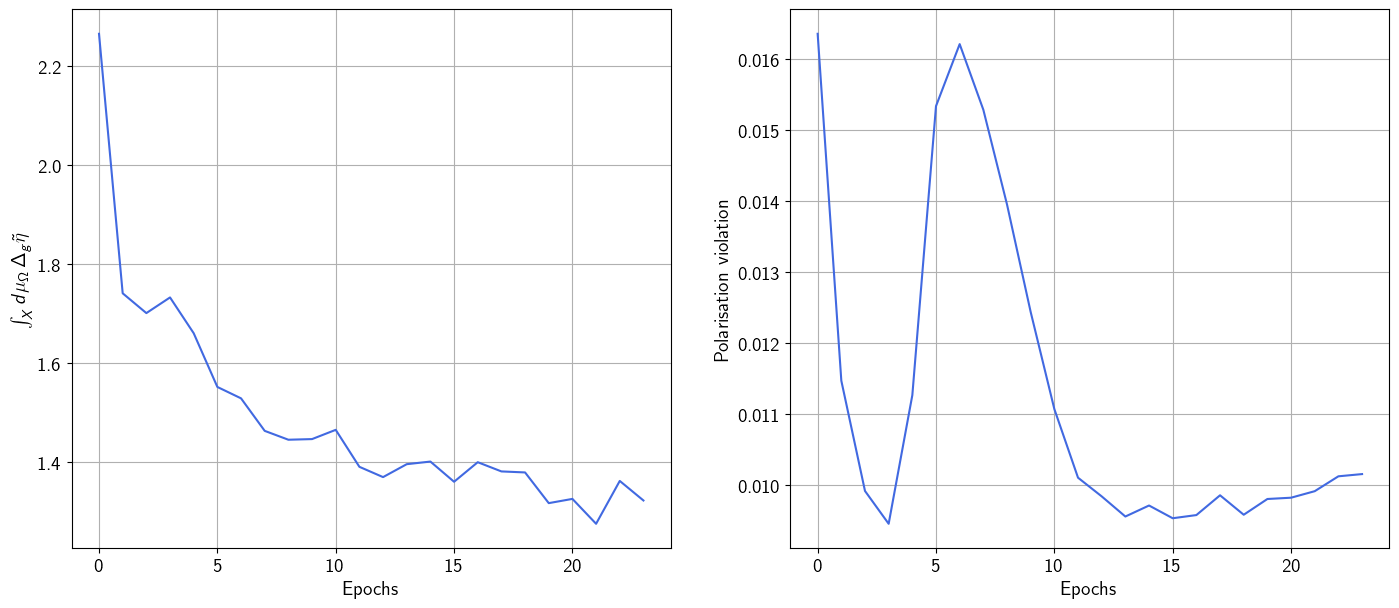

In [15]:
fig = plt.figure(figsize=(17,7))
gs=GridSpec(1,2)
ax1=fig.add_subplot(gs[0,0])
ax2=fig.add_subplot(gs[0,1])

S = np.abs(storage['codiff_mean'])
n = 32
ax1.plot(np.arange(len(S))[:n], np.abs(S)[:n], c='royalblue')
ax1.set_xlabel(f'Epochs')
ax1.set_ylabel(r'$\int_X d\mu_{\Omega} \, \Delta_g \tilde{\eta}$')
ax1.grid(True, 'both')
# ax1.set_yscale('log')

R = storage['polarisation']
ax2.plot(np.arange(len(R))[:n], np.abs(R)[:n], c='royalblue')
ax2.set_xlabel(f'Epochs')
ax2.set_ylabel(r'Polarisation violation')
ax2.grid(True, 'both')
# ax2.set_yscale('log')

## Yukawa coupling computation
For the particular class of string models we consider, we can calculate physical observables ('Yukawa couplings') via two ways:

* A computation from deformation theory, exact up to integration error.
* Using the approximate harmonic forms we have just optimised for.

The purpose of this experiment is really a sanity check to ensure that our proposed method can generalise to other string models where there is no equivalent of deformation theory applicable, and the approximate harmonic forms are the only avenue for calculation of certain physical observables.
We compare above methods below via an evaluation on the validation set.

In [16]:
val_data_batched, psi = dataloading._batch_aux(
    "data/X33_demo/dataset.npz", 1024, 'x_val',
    metadata_key='psi', aux_keys=('y_val',), precision = np.float32)

Dataset size: (200000, 12), meta: 0.5000000


In [17]:
# clunky but gets the job done
def normalised_cubic_yukawas_batched(harmonic_wp, params, data_loader):
    from cymyc.utils import math_utils
    
    wp, kappa = 0., 0.
    vol_Omega, int_a, int_aa_p_bb = 0., 0., 0.
    dQdz_monomials, dQdz_coeffs = harmonic_wp.dQdz_monomials, harmonic_wp.dQdz_coeffs
    metric_fn, deformation_fn, pb_fn = harmonic_wp.metric_fn, harmonic_wp.deformation, harmonic_wp.pb_fn
    n = 0
    for _data in tqdm(zip(*data_loader), total=len(data_loader[0])):
        p, aux = _data
        p_c = math_utils.to_complex(p)
        weights, dVol_Omega = aux[:,0], aux[:,1]
        pullbacks = jax.vmap(pb_fn)(math_utils.to_complex(p))
        B = p.shape[0]
        _data = (p, weights, dVol_Omega)

        _vol_Omega, _int_a, _int_aa_p_bb = harmonic_wp._compute_wp_metric_diagonal_batch_i(
                                                p_c, weights, pullbacks, dQdz_monomials,
                                                dQdz_coeffs, deformation_fn)

        vol_Omega = math_utils.online_update(vol_Omega, _vol_Omega, n, B)
        int_a = math_utils.online_update(int_a, _int_a, n, B)
        int_aa_p_bb = math_utils.online_update(int_aa_p_bb, _int_aa_p_bb, n, B)

        # Trilinear coupling
        _kappa = harmonic_wp.yukawas(
            p_c, dQdz_monomials, dQdz_coeffs, deformation_fn, deformation_fn,
            deformation_fn, weights, pullbacks)
        kappa = math_utils.online_update(kappa, _kappa, n, B)

        _g_pred = jax.vmap(metric_fn)(p)
        _eta, *_ = jax.vmap(harmonic_wp.harmonic_rep_breakdown, in_axes=(0,None))(p, params)
        _wp = harmonic_wp.inner_product_Hodge(_data, _eta, _g_pred)
        wp = math_utils.online_update(wp, _wp, n, B)
        n += B

    yuk_normalised = jnp.abs(kappa) / (vol_Omega) * wp**(-3/2)
    g_wp_KS = -int_aa_p_bb / vol_Omega + (jnp.conjugate(int_a) * int_a) / vol_Omega**2

    return {
        "yuk_normalised":   yuk_normalised,
        "kappa":            kappa,
        "wp":               wp,
        "vol_Omega":        vol_Omega,
        "wp_KS":            g_wp_KS}

In [25]:
yukawa_data = normalised_cubic_yukawas_batched(harmonic_wp, params, val_data_batched)
yukawa_data

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:04<00:00, 45.26it/s]


{'yuk_normalised': Array([[1.05401036-2.11681805e-09j]], dtype=complex128),
 'kappa': Array(-0.34893425+0.00036452j, dtype=complex128),
 'wp': Array([[0.60348005+8.07998037e-10j]], dtype=complex128),
 'vol_Omega': Array(0.7061624, dtype=float32),
 'wp_KS': Array(0.60354024-8.16948023e-21j, dtype=complex128)}

In [26]:
yukawa_data = jax.tree_util.tree_map(lambda x: x.item(), yukawa_data)

In [27]:
print(f"Normalized Yukawa coupling λ @ (ψ={psi}) = {yukawa_data['yuk_normalised']:.07f}")
print(f"Harmonic calculation: WP @ (ψ={psi}) = {yukawa_data['wp']:.07f}")
print(f"Kodaira-Spencer calculation: WP @ (ψ={psi}) = {yukawa_data['wp_KS']:.07f}")
print(f"Relative error in Weil-Petersson metric = {np.abs((yukawa_data['wp'] - yukawa_data['wp_KS'])/yukawa_data['wp_KS'])*100:.04f}%")

Normalized Yukawa coupling λ @ (ψ=0.5) = 1.0540104-0.0000000j
Harmonic calculation: WP @ (ψ=0.5) = 0.6034800+0.0000000j
Kodaira-Spencer calculation: WP @ (ψ=0.5) = 0.6035402-0.0000000j
Relative error in Weil-Petersson metric = 0.0100%
